In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import logging
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [101]:
# Definiere Start- und Enddatum
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Funktion zur Aufbereitung der Datensätze
def prepare_dataset(df, start_date, end_date):
    # Erstelle eine Kopie des DataFrames
    df = df.copy()
    
    # Konvertiere Timestamp zu datetime und setze als Index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    
    # Schneide den Zeitraum direkt nach der Indexerstellung
    df = df[start_date:end_date].copy()
    
    # Entferne Timestamp-Duplikate (behalte den ersten Eintrag)
    df = df[~df.index.duplicated(keep='first')]
    
    # Konvertiere alle numerischen Spalten zu float
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df.loc[:, column] = df[column].astype(float)
        except ValueError:
            print(f"Konnte Spalte {column} nicht zu float konvertieren")
    
    return df

# Importiere und bereite die Datensätze auf
air_quality = pd.read_csv('dataset/Veenkampen_Air Quality.csv', skiprows=[1])
air_quality = prepare_dataset(air_quality, start_date, end_date)

meteorology = pd.read_csv('dataset/Veenkampen_Meteorology.csv', skiprows=[1])
meteorology = prepare_dataset(meteorology, start_date, end_date)

soil = pd.read_csv('dataset/Veenkampen_Soil.csv', skiprows=[1])
soil = prepare_dataset(soil, start_date, end_date)

# Importiere und bereite das Flux Dataset auf
fluxes = pd.read_csv('./dataset/Veenkampen_Fluxes.csv', skiprows=[1]) # Entferne die Einheitenzeile
fluxes = prepare_dataset(fluxes, start_date, end_date)

# Zeige Informationen über alle aufbereiteten Datensätze
print("\nZeitraum der Datensätze:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(f"Start: {df.index.min()}")
    print(f"Ende: {df.index.max()}")
    print(f"Anzahl Datenpunkte: {len(df)}")

# Zeige Informationen über die Datensätze
print("\nDataset Infos:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name} Dataset Info:")
    print(df.info())

# Überprüfe auf fehlende Werte
print("\nFehlende Werte:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\nFehlende Werte in {name}:")
    print(df.isnull().sum())

# Überprüfe die Sampling-Raten
print("\nSampling-Intervalle:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(df.index.to_series().diff().value_counts().head())








Zeitraum der Datensätze:

Air Quality:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:56:00
Anzahl Datenpunkte: 979527

Meteorology:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:59:00
Anzahl Datenpunkte: 4720489

Soil:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:59:00
Anzahl Datenpunkte: 4717918

Fluxes:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:30:00
Anzahl Datenpunkte: 140422

Dataset Infos:

Air Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979527 entries, 2015-01-01 00:00:00 to 2023-12-31 23:56:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   co2_mixing_ratio  130219 non-null  float64
 1   h2o_mixing_ratio  140145 non-null  float64
 2   BC                362135 non-null  float64
 3   NOx               646041 non-null  float64
 4   NO                646041 non-null  float64
 5   NO2               646041 non-null  float64
 6   O3                628638 non-nu

In [18]:
# Definiere Start- und Enddatum
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Import the file from the specified directory
file_path = './dataset/Veenkampen_Fluxes.csv'
data = pd.read_csv(file_path)
# Remove the first row of the dataset
data = data.drop(index=0).reset_index(drop=True)
#Convert 'Timestamp' to a DateTime object and set it as the index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')


data.set_index('Timestamp', inplace = True)

data = data[start_date:end_date]


# Display the first few rows of the updated dataframe
data.head()
print(f"Ende: {data.index.max()}")

Ende: 2023-12-31 23:30:00


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_4513/2930265294.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [64]:
fluxes.dtypes

Tau                  float64
qc_Tau                 int64
H                    float64
qc_H                   int64
qc_LE                float64
co2_flux             float64
qc_co2_flux          float64
h2o_flux             float64
qc_h2o_flux          float64
co2_mole_fraction    float64
h2o_mole_fraction    float64
u*                   float64
L                    float64
u_var                float64
v_var                float64
w_var                float64
ts_var               float64
LE                   float64
Rn                   float64
dtype: object

In [21]:
#Transform  data to float
cols = ['Tau', 'qc_Tau', 'H', 'qc_H', 'qc_LE', 'co2_flux', 'qc_co2_flux',
        'h2o_flux', 'qc_h2o_flux', 'co2_mole_fraction', 'h2o_mole_fraction',
        'u*', 'L', 'u_var', 'v_var', 'w_var', 'ts_var', 'LE']

for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [9]:
nan_counts = fluxes['co2_flux'].isna().sum()
print(f"Number of missing data: {nan_counts}")

# Number of NaN groups
missing_blocks = fluxes['co2_flux'].isna().astype(int).groupby(fluxes['co2_flux'].notna().astype(int).cumsum()).sum()
print(missing_blocks.sort_values(ascending=False).head(10))  # longest NaN sequences

Number of missing data: 10216
co2_flux
28073     350
35036     131
35007     128
23693     116
23463     109
23692      92
107721     84
23689      60
35075      53
9772       43
Name: co2_flux, dtype: int64


In [56]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [123]:
# Load dataset (Ensure the correct data path is used)
data = fluxes['co2_flux'].copy()

# 1. Basic descriptive analysis of CO2 flux values
print("=== Descriptive Statistics ===")
print(data.describe())

# 2. Outlier detection using the Interquartile Range (IQR) method
# The IQR method is a robust statistical approach to identify potential outliers by assessing the data spread between the first (Q1) and third quartiles (Q3).
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
iqr_low = q1 - 1.5 * iqr  # Lower bound for moderate outliers
iqr_high = q3 + 1.5 * iqr  # Upper bound for moderate outliers

print(f"\nIQR-based thresholds: [{iqr_low:.2f}, {iqr_high:.2f}] µmol/m²/s")

# 3. Defining alternative thresholds using the 5th and 95th percentiles
# The 95% confidence interval captures the central distribution of the data, reducing the influence of extreme values.
p05, p95 = data.quantile([0.05, 0.95])
print(f"\n95% range: [{p05:.2f}, {p95:.2f}] µmol/m²/s")

# 4. Justification for threshold selection
# The IQR method is highly effective for detecting moderate outliers but may exclude valid extreme observations in dynamic natural systems.
# The 95% percentile approach is more flexible, preserving a broader range of natural variation while filtering extreme anomalies.
# For conservative outlier removal, IQR is recommended.
# For a more inclusive approach that retains natural variability, the 95% range is preferable.

# 5. Data cleaning using both methods

# Approach 1: IQR-based filtering
clean_data_iqr = data.where(
    (data >= iqr_low) & 
    (data <= iqr_high)
)

# Approach 2: 95%-based filtering
clean_data_95 = data.where(
    (data >= p05) & 
    (data <= p95)
)

# Compare data retention after filtering
print(f"\nRemaining data after filtering (IQR applied): {clean_data_iqr.count() / len(data):.1%}")
print(f"Remaining data after filtering (95% range applied): {clean_data_95.count() / len(data):.1%}")

=== Descriptive Statistics ===
count    1.302190e+05
mean     6.126728e+06
std      1.579221e+09
min     -5.072780e+02
25%     -5.093183e+00
50%      5.899440e-01
75%      3.217230e+00
max      4.559529e+11
Name: co2_flux, dtype: float64

IQR-based thresholds: [-17.56, 15.68] µmol/m²/s

95% range: [-14.81, 11.78] µmol/m²/s

Remaining data after filtering (IQR applied): 86.2%
Remaining data after filtering (95% range applied): 83.5%


Statistics of cleaned co2_flux (outliers removed):
count    117194.000000
mean         -0.718166
std           5.479319
min         -14.799859
25%          -4.354316
50%           0.591012
75%           2.861450
max          11.798248
Name: co2_flux_clean, dtype: float64


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/3553001250.py:106: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


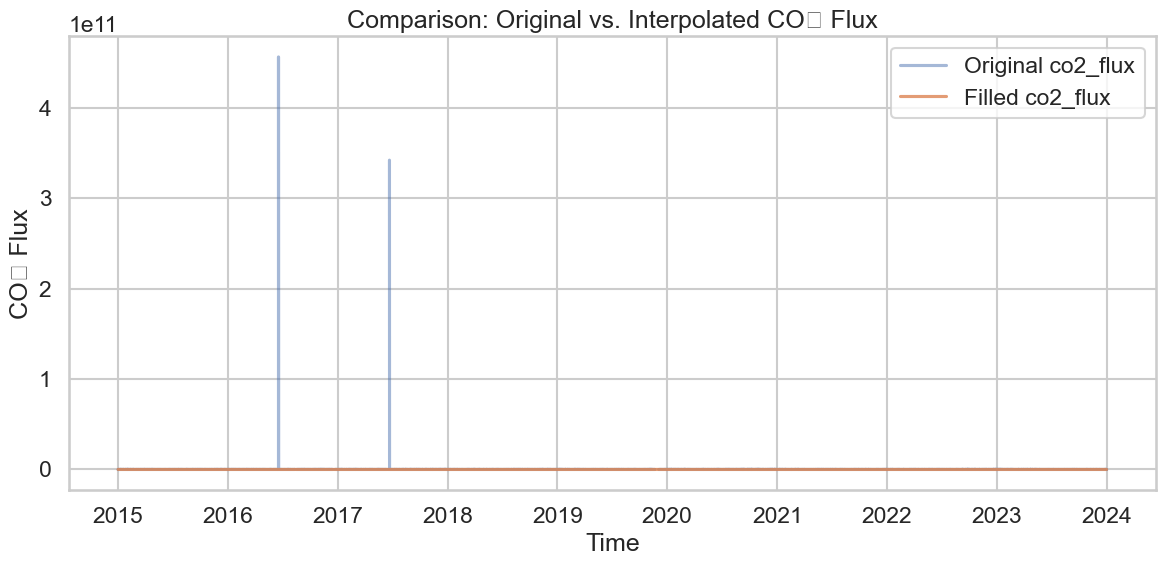


Statistics of filled co2_flux:
count    140422.000000
mean         -0.703675
std           5.536560
min         -14.799859
25%          -4.348007
50%           0.613685
75%           2.924029
max          11.798248
Name: co2_flux_filled, dtype: float64


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Assumption: The datasets (air_quality, meteorology, soil, fluxes) are already imported and prepared.

# ---------------------------------
# 0. Preparation: Interpolation of solar radiation data
# ---------------------------------
# The variable SW_IN_1_1_1 from the meteorology dataset is used for day/night determination.
# Interpolate missing values in SW_IN_1_1_1 using time-based interpolation.
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].interpolate(method='time', limit_direction='both')

# To align solar radiation data with flux timestamps, reindex the meteorological SW_IN values 
# to match the flux dataset's time grid using the nearest method, as meteorological data is at 1-minute intervals.
flux_df = fluxes.copy()
flux_df['SW_IN'] = meteorology['SW_IN_1_1_1'].reindex(flux_df.index, method='nearest')

# ---------------------------------
# 1. Statistical analysis and outlier removal of CO₂ flux data
# ---------------------------------
# Copy the original CO₂ flux data into a new column
flux_df['co2_flux_clean'] = flux_df['co2_flux'].copy()

# Set values outside the 95% range (less than -14.8 or greater than 11.8) as outliers to NaN
flux_df.loc[(flux_df['co2_flux_clean'] < -14.8) | (flux_df['co2_flux_clean'] > 11.8), 'co2_flux_clean'] = np.nan

print("Statistics of cleaned co2_flux (outliers removed):")
print(flux_df['co2_flux_clean'].describe())

# ---------------------------------
# 2. Preparation for interpolation: Differentiating between short and long gaps
# ---------------------------------
# Determine the typical sampling interval in hours (median of time differences)
median_interval = flux_df.index.to_series().diff().median().total_seconds() / 3600.0

# Perform an initial linear time interpolation to fill all gaps
flux_df['co2_flux_lin'] = flux_df['co2_flux_clean'].interpolate(method='time', limit_direction='both')

# Identify indices of gaps longer than 1.5 hours
na_mask = flux_df['co2_flux_clean'].isna()
group_ids = (na_mask != na_mask.shift()).cumsum()
missing_groups = flux_df[na_mask].groupby(group_ids)

long_gap_indices = []
for group_id, group in missing_groups:
    # Compute the gap duration (difference between first and last timestamp plus one typical interval)
    gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
    if gap_duration > 1.5:
        long_gap_indices.extend(group.index)

# Reset values in the linearly interpolated series to NaN for long gaps
flux_df.loc[long_gap_indices, 'co2_flux_lin'] = np.nan

# ---------------------------------
# 3. Definition of day/night determination using solar radiation
# ---------------------------------
# Daytime is assumed when SW_IN > 20 W/m², otherwise, it is considered nighttime.
def is_day(timestamp):
    # Use the interpolated SW_IN value from the flux dataset for the given timestamp.
    # If the value is missing, default to nighttime.
    sw_value = flux_df.at[timestamp, 'SW_IN'] if pd.notnull(flux_df.at[timestamp, 'SW_IN']) else 0
    return sw_value > 20

# ---------------------------------
# 4. Gap filling using Marginal Distribution Sampling (MDS)
# ---------------------------------
# For each timestamp in long gaps, a random value is drawn from the empirical distribution of cleaned CO₂ flux data,
# based on whether it is day or night.
for ts in long_gap_indices:
    if is_day(ts):
        # Select all valid values in the daytime period (SW_IN > 20)
        pool = flux_df.loc[flux_df['SW_IN'] > 20, 'co2_flux_clean'].dropna()
    else:
        # Select all valid values in the nighttime period (SW_IN <= 20)
        pool = flux_df.loc[flux_df['SW_IN'] <= 20, 'co2_flux_clean'].dropna()
    
    if len(pool) > 0:
        flux_df.at[ts, 'co2_flux_lin'] = np.random.choice(pool.values)
    else:
        flux_df.at[ts, 'co2_flux_lin'] = np.nan

# The combined result (linear interpolation for short gaps, MDS for long gaps) 
# is stored in the column 'co2_flux_filled'.
flux_df['co2_flux_filled'] = flux_df['co2_flux_lin']

# ---------------------------------
# 5. Interpolation of external variables in the flux dataset
# ---------------------------------
# Perform a simple time interpolation for all other variables with missing values.
cols_to_exclude = ['co2_flux', 'co2_flux_clean', 'co2_flux_lin', 'co2_flux_filled', 'SW_IN']
external_cols = [col for col in flux_df.columns if col not in cols_to_exclude]

if external_cols:
    flux_df[external_cols] = flux_df[external_cols].interpolate(method='time', limit_direction='both')

# ---------------------------------
# 6. Visualization and final statistics
# ---------------------------------
plt.figure(figsize=(12, 6))
plt.plot(flux_df.index, flux_df['co2_flux'], label='Original co2_flux', alpha=0.5)
plt.plot(flux_df.index, flux_df['co2_flux_filled'], label='Filled co2_flux', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("CO2 Flux")
plt.title("Comparison: Original vs. Interpolated CO₂ Flux")
plt.legend()
plt.tight_layout()
plt.show()

print("\nStatistics of filled co2_flux:")
print(flux_df['co2_flux_filled'].describe())


# Data Visualization

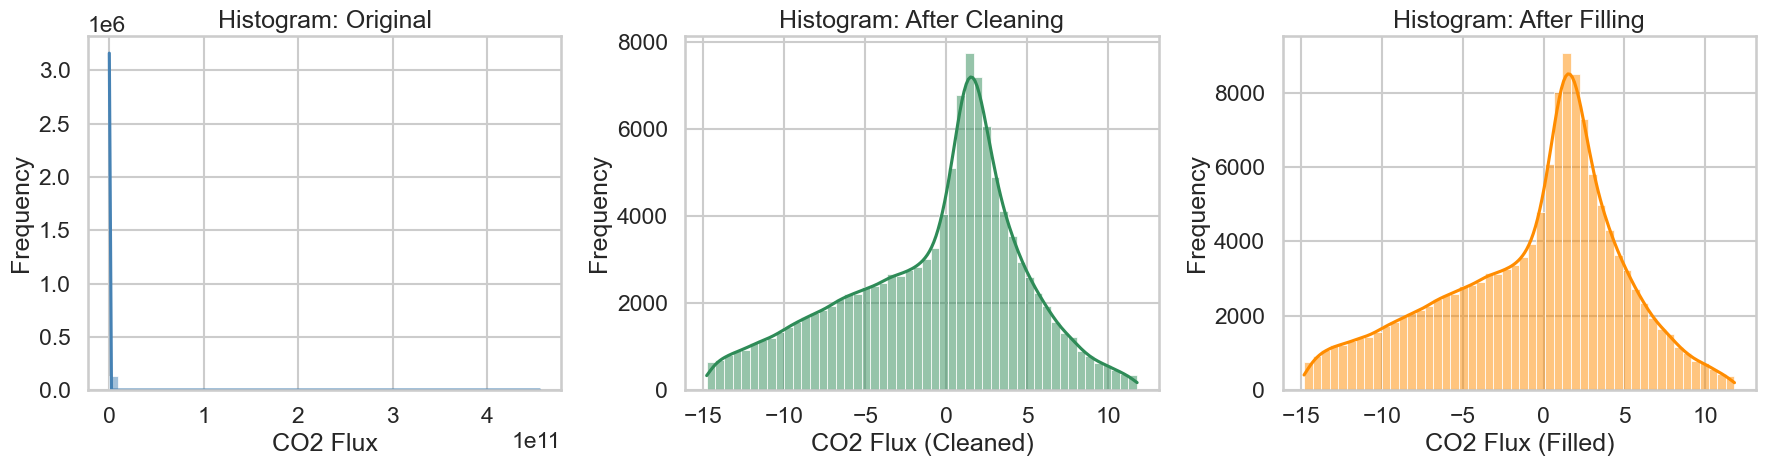

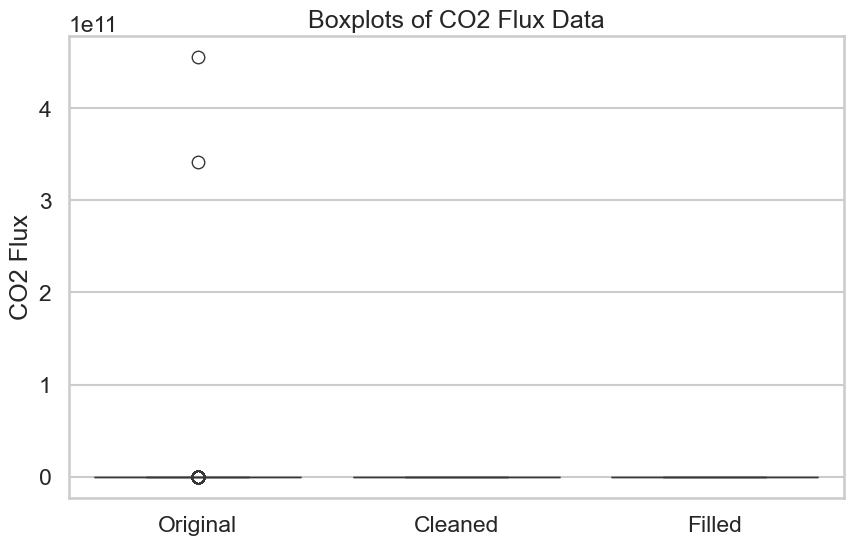

/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/1883162393.py:64: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux'].dropna(), label="Original", shade=True, color="steelblue")
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/1883162393.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux_clean'].dropna(), label="Cleaned", shade=True, color="seagreen")
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/1883162393.py:66: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux_filled'].dropna(), label="Filled", shade=True, color="darkora

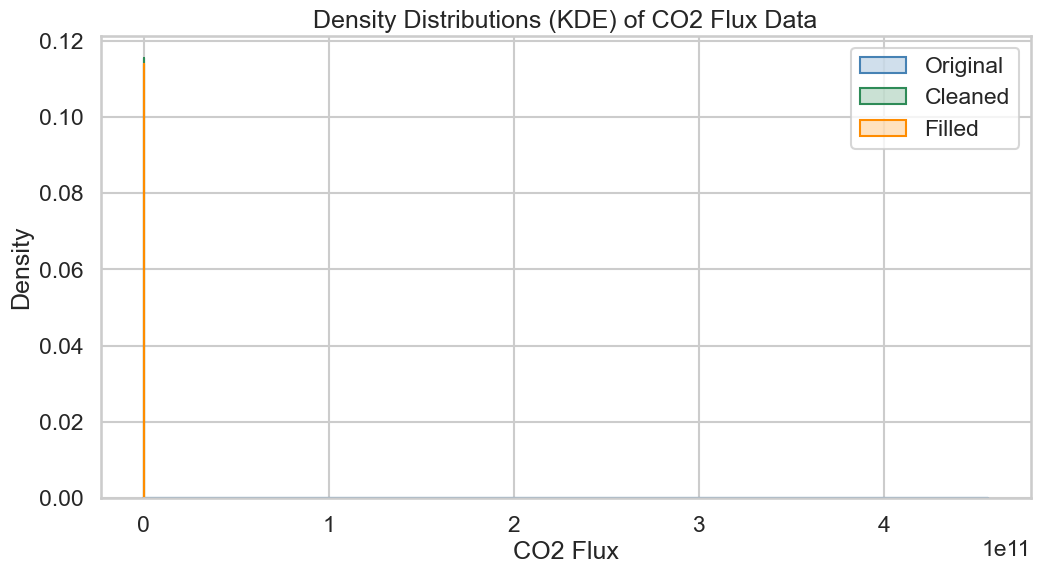

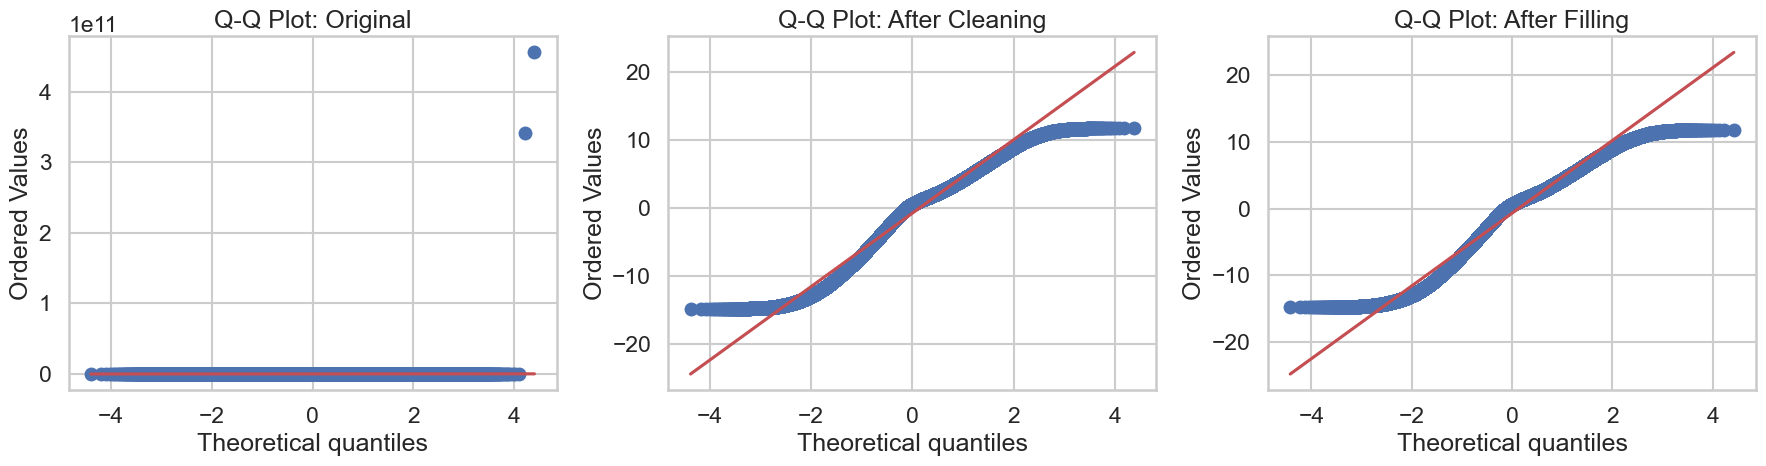

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Import the necessary libraries

# Set a style for the plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({'figure.max_open_warning': 0})

# Assumption: flux_df is already available and contains the following columns:
# - 'co2_flux': Original data
# - 'co2_flux_clean': After outlier removal (values outside [-14.8, 11.8] were removed)
# - 'co2_flux_filled': After interpolation (linear interpolation for short gaps and MDS for long gaps)

# ---------------------------------
# 1. Histograms with KDE (Density Curves)
# ---------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(flux_df['co2_flux'], bins=50, kde=True, color="steelblue")
plt.title("Histogram: Original")
plt.xlabel("CO2 Flux")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
sns.histplot(flux_df['co2_flux_clean'], bins=50, kde=True, color="seagreen")
plt.title("Histogram: After Cleaning")
plt.xlabel("CO2 Flux (Cleaned)")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
sns.histplot(flux_df['co2_flux_filled'], bins=50, kde=True, color="darkorange")
plt.title("Histogram: After Filling")
plt.xlabel("CO2 Flux (Filled)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ---------------------------------
# 2. Boxplots to Compare Distributions
# ---------------------------------
# Create a DataFrame containing the three versions for easier boxplot visualization.
df_box = pd.DataFrame({
    "Original": flux_df['co2_flux'],
    "Cleaned": flux_df['co2_flux_clean'],
    "Filled": flux_df['co2_flux_filled']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, palette=["steelblue", "seagreen", "darkorange"])
plt.title("Boxplots of CO2 Flux Data")
plt.ylabel("CO2 Flux")
plt.show()

# ---------------------------------
# 3. Density Distributions (KDE) Comparison
# ---------------------------------
plt.figure(figsize=(12, 6))
sns.kdeplot(flux_df['co2_flux'].dropna(), label="Original", shade=True, color="steelblue")
sns.kdeplot(flux_df['co2_flux_clean'].dropna(), label="Cleaned", shade=True, color="seagreen")
sns.kdeplot(flux_df['co2_flux_filled'].dropna(), label="Filled", shade=True, color="darkorange")
plt.title("Density Distributions (KDE) of CO2 Flux Data")
plt.xlabel("CO2 Flux")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---------------------------------
# 4. Q-Q Plots to Check Normality Assumption
# ---------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Q-Q Plot for Original Data
stats.probplot(flux_df['co2_flux'].dropna(), dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Original")

# Q-Q Plot for Cleaned Data
stats.probplot(flux_df['co2_flux_clean'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot: After Cleaning")

# Q-Q Plot for Filled Data
stats.probplot(flux_df['co2_flux_filled'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot: After Filling")

plt.tight_layout()
plt.show()

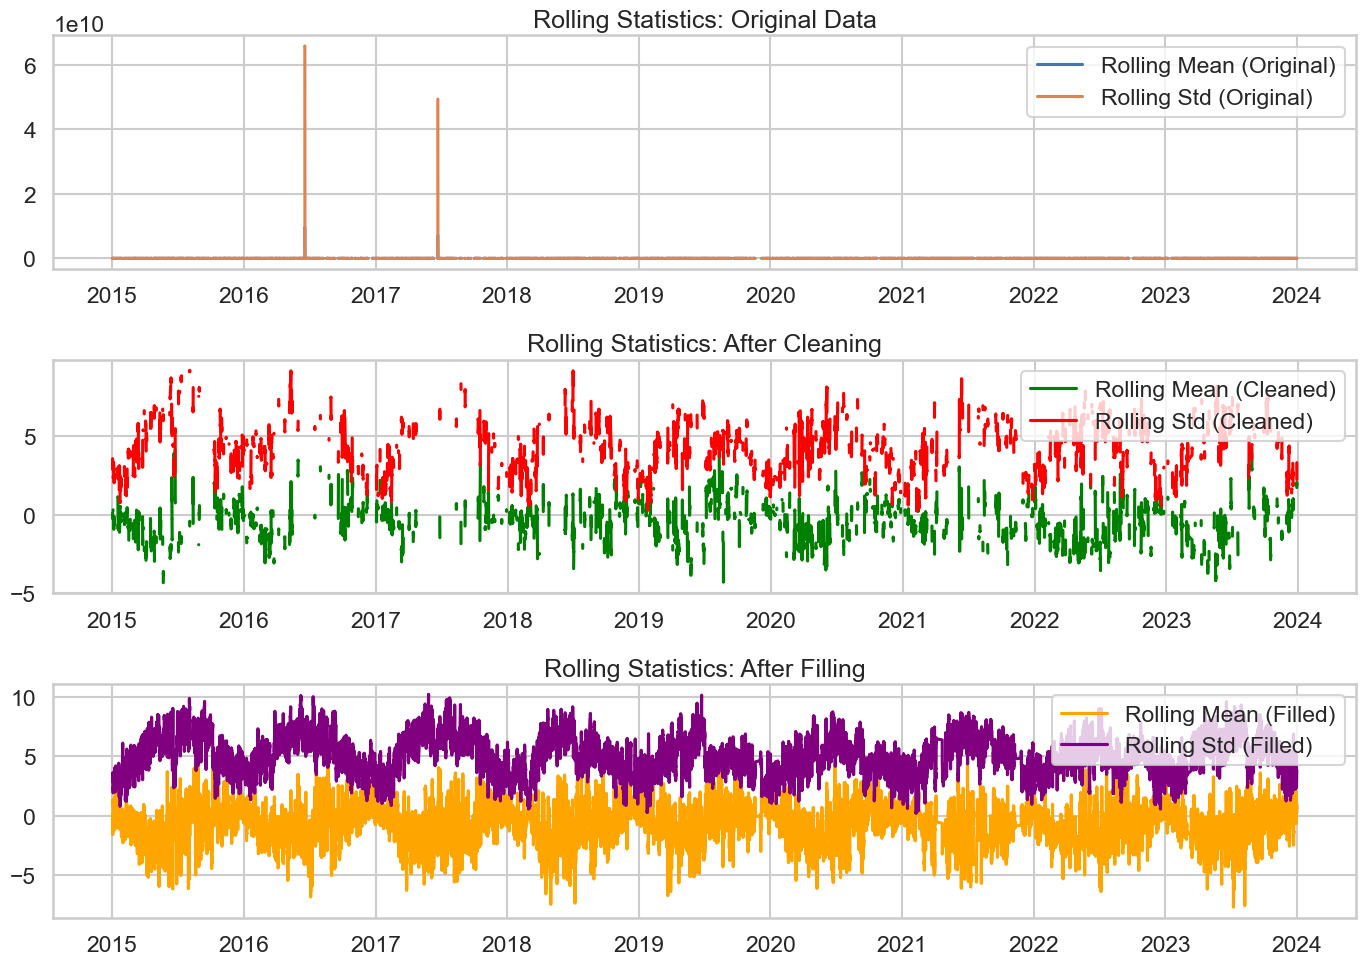

In [119]:
# ---------------------------------
# 5. Rolling Statistics Analysis
# ---------------------------------
# Define the rolling window size (e.g., 48 steps for 30-minute data ~ 24 hours)
window_size = 48

# Compute rolling mean and standard deviation for original, cleaned, and filled datasets
flux_df['roll_mean_orig'] = flux_df['co2_flux'].rolling(window=window_size).mean()
flux_df['roll_std_orig'] = flux_df['co2_flux'].rolling(window=window_size).std()

flux_df['roll_mean_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).mean()
flux_df['roll_std_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).std()

flux_df['roll_mean_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).mean()
flux_df['roll_std_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).std()

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(flux_df.index, flux_df['roll_mean_orig'], label='Rolling Mean (Original)')
plt.plot(flux_df.index, flux_df['roll_std_orig'], label='Rolling Std (Original)')
plt.title("Rolling Statistics: Original Data")
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.plot(flux_df.index, flux_df['roll_mean_clean'], label='Rolling Mean (Cleaned)', color='green')
plt.plot(flux_df.index, flux_df['roll_std_clean'], label='Rolling Std (Cleaned)', color='red')
plt.title("Rolling Statistics: After Cleaning")
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.plot(flux_df.index, flux_df['roll_mean_filled'], label='Rolling Mean (Filled)', color='orange')
plt.plot(flux_df.index, flux_df['roll_std_filled'], label='Rolling Std (Filled)', color='purple')
plt.title("Rolling Statistics: After Filling")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

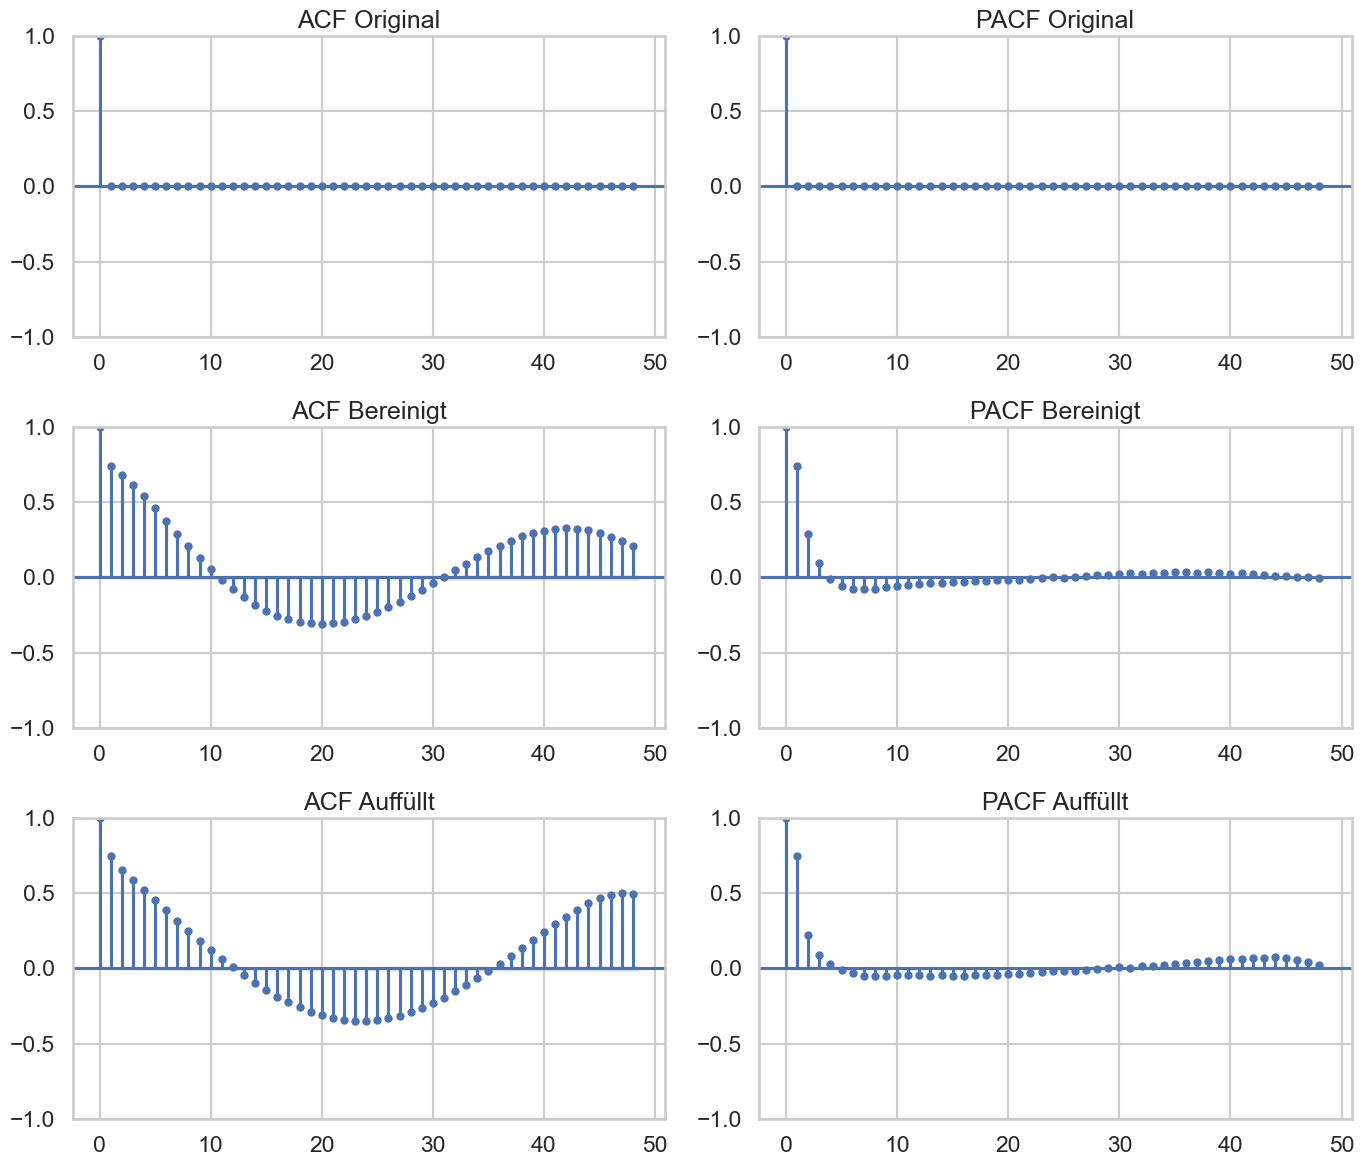

In [106]:


# Create a figure with subplots for ACF and PACF plots across different data versions
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Original data: Analyze autocorrelation and partial autocorrelation
sm.graphics.tsa.plot_acf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 0], title='ACF Original')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 1], title='PACF Original')

# Cleaned data: Assess the impact of outlier removal on autocorrelation structure
sm.graphics.tsa.plot_acf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 0], title='ACF Cleaned')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 1], title='PACF Cleaned')

# Filled data: Examine the influence of interpolation on temporal dependencies
sm.graphics.tsa.plot_acf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 0], title='ACF Filled')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 1], title='PACF Filled')

# Optimize layout for better readability
plt.tight_layout()
plt.show()

2025-02-19 15:26:23 DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998.
2025-02-19 15:26:23 DEBUG: findfont: score(FontEntry(fname='/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-02-19 15:26:23 DEBUG: findfont: score(FontEntry(fname='/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-02-19 15:26:23 DEBUG: findfont: score(FontEntry(fname='/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='norm

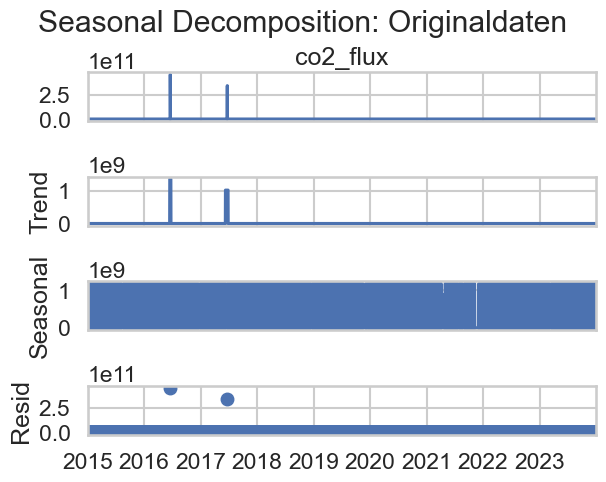

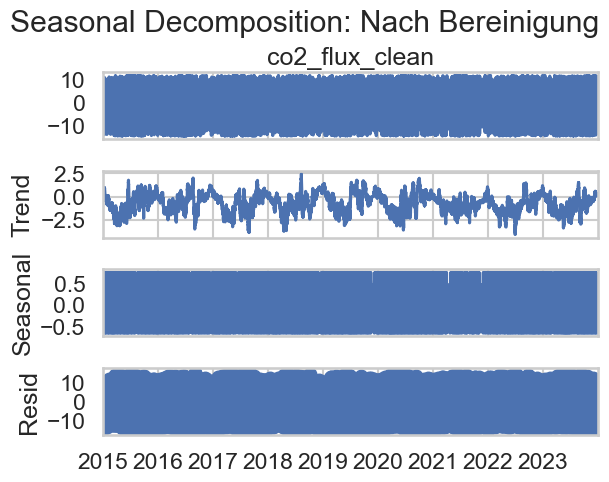

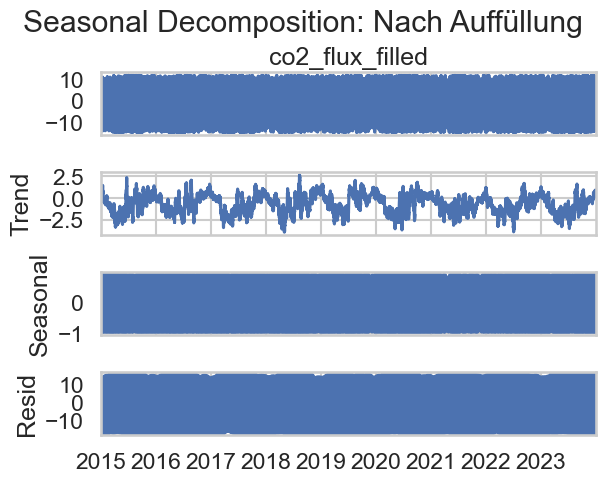

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Beispielhaft mit wöchentlicher Frequenz, je nach Sampling-Rate anpassen:
freq_steps = 48 * 7  # bei 30-Minuten-Daten ~ eine Woche

# Original
decomp_orig = seasonal_decompose(flux_df['co2_flux'].dropna(), period=freq_steps, model='additive')
fig_orig = decomp_orig.plot()
fig_orig.suptitle("Seasonal Decomposition: Originaldaten", y=1.02)

# Bereinigt
decomp_clean = seasonal_decompose(flux_df['co2_flux_clean'].dropna(), period=freq_steps, model='additive')
fig_clean = decomp_clean.plot()
fig_clean.suptitle("Seasonal Decomposition: Nach Bereinigung", y=1.02)

# Auffüllt
decomp_filled = seasonal_decompose(flux_df['co2_flux_filled'].dropna(), period=freq_steps, model='additive')
fig_filled = decomp_filled.plot()
fig_filled.suptitle("Seasonal Decomposition: Nach Auffüllung", y=1.02)

plt.show()



Analyse für Täglich (Periode=48)



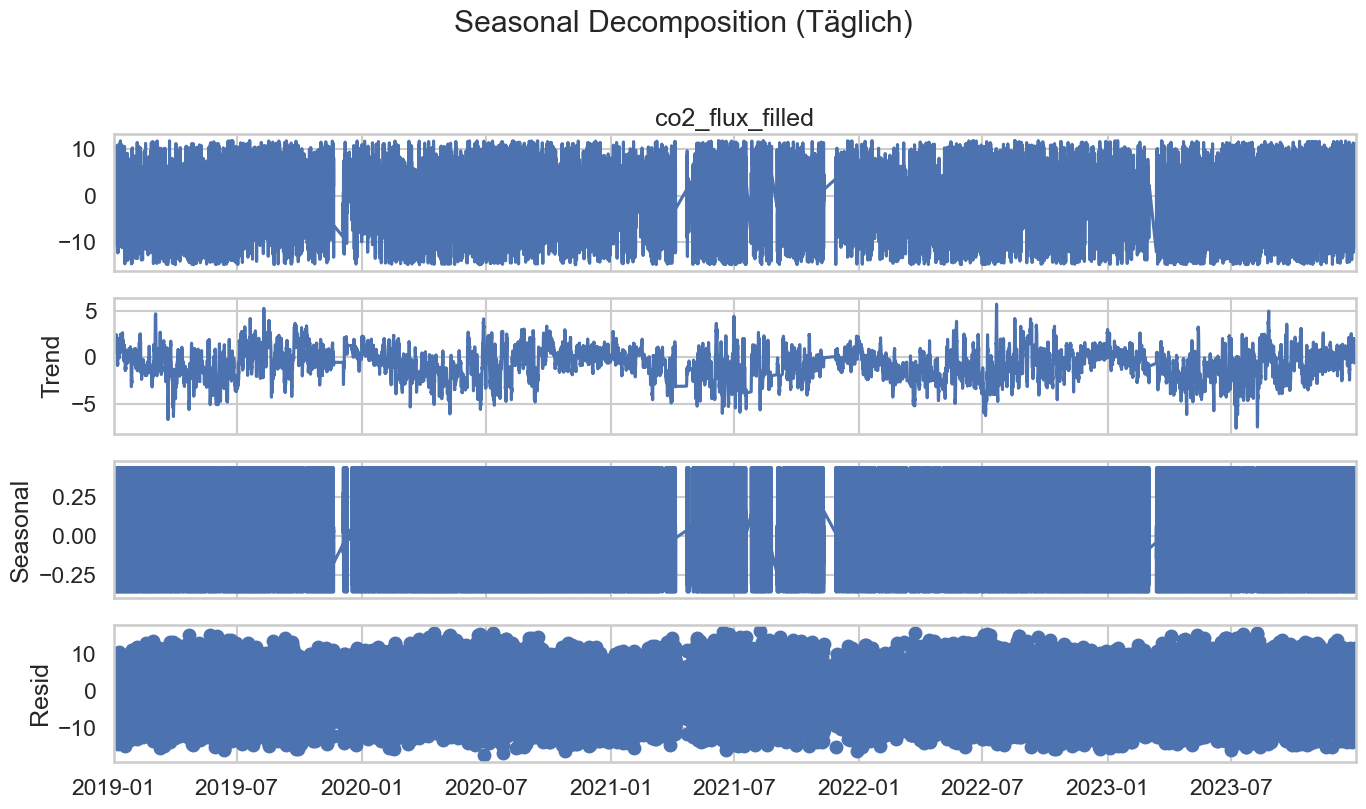


=== ADF: Täglich - Originalserie ===
  Teststatistik: -31.968998903256754
  p-Wert: 0.0
  # Lags: 72
  # Beobachtungen: 140349
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Täglich - Originalserie ===
  Teststatistik: 0.34647634458904214
  p-Wert: 0.1
  # Lags: 143
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)

=== ADF: Täglich - Residuen ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Teststatistik: -76.51044268802987
  p-Wert: 0.0
  # Lags: 74
  # Beobachtungen: 140347
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Täglich - Residuen ===
  Teststatistik: 0.00036479714492606115
  p-Wert: 0.1
  # Lags: 110
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)


Analyse für Wöchentlich (Periode=336)



/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


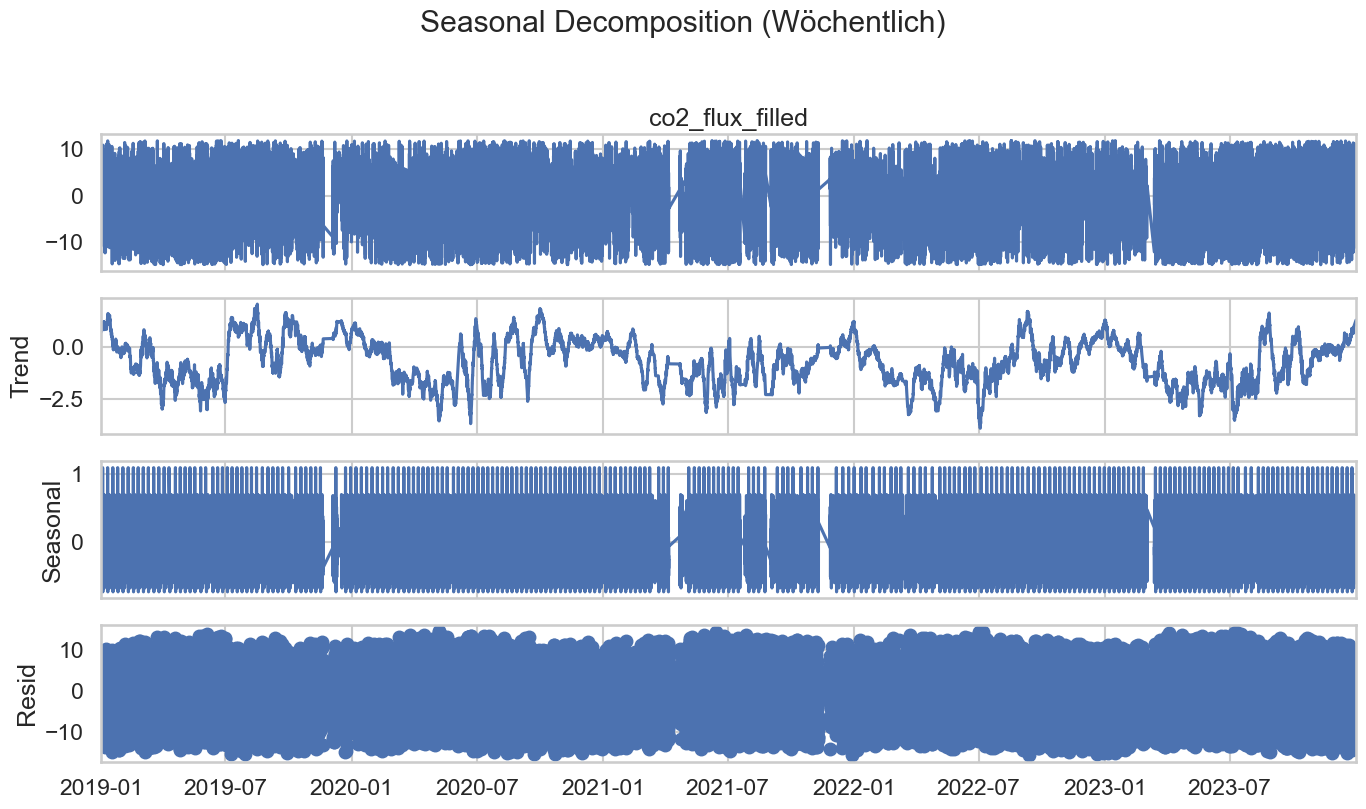


=== ADF: Wöchentlich - Originalserie ===
  Teststatistik: -31.968998903256754
  p-Wert: 0.0
  # Lags: 72
  # Beobachtungen: 140349
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Wöchentlich - Originalserie ===
  Teststatistik: 0.34647634458904214
  p-Wert: 0.1
  # Lags: 143
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)

=== ADF: Wöchentlich - Residuen ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Teststatistik: -48.58033892729299
  p-Wert: 0.0
  # Lags: 74
  # Beobachtungen: 140347
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Wöchentlich - Residuen ===
  Teststatistik: 0.0011234912919117167
  p-Wert: 0.1
  # Lags: 133
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)


Analyse für Monatlich (Periode=1440)



/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


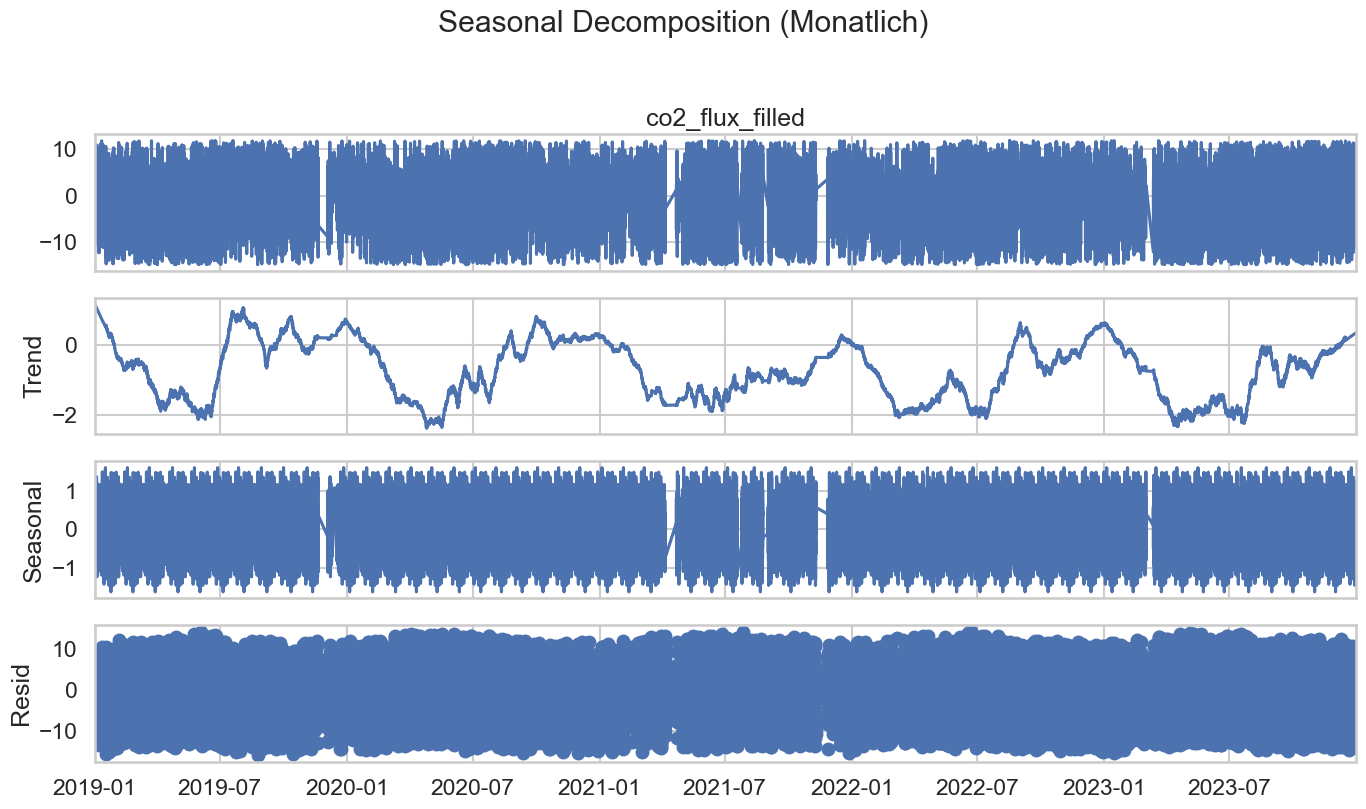


=== ADF: Monatlich - Originalserie ===
  Teststatistik: -31.968998903256754
  p-Wert: 0.0
  # Lags: 72
  # Beobachtungen: 140349
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Monatlich - Originalserie ===
  Teststatistik: 0.34647634458904214
  p-Wert: 0.1
  # Lags: 143
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)

=== ADF: Monatlich - Residuen ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Teststatistik: -39.24908214107086
  p-Wert: 0.0
  # Lags: 74
  # Beobachtungen: 140347
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Monatlich - Residuen ===
  Teststatistik: 0.0019041881774998094
  p-Wert: 0.1
  # Lags: 137
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)


Analyse für Jährlich (Periode=17520)



/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


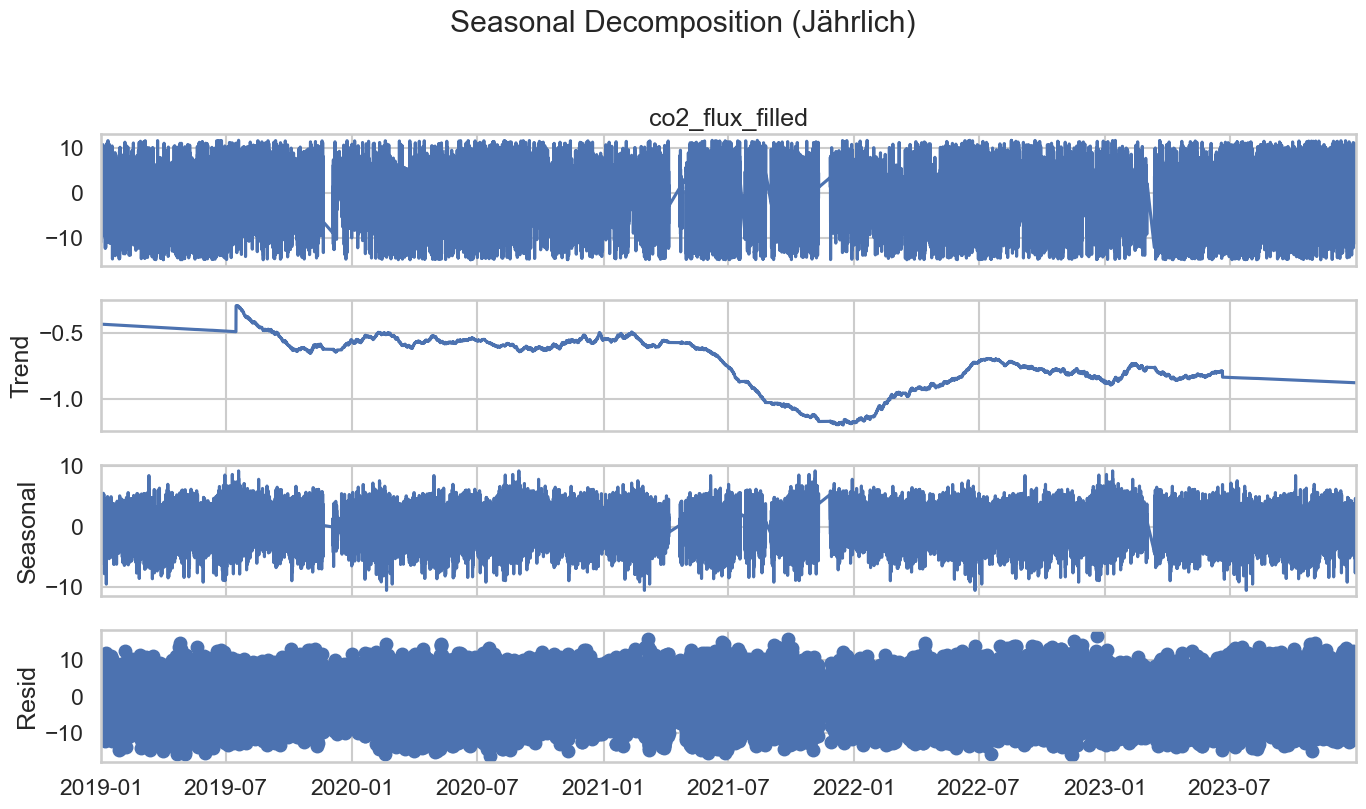


=== ADF: Jährlich - Originalserie ===
  Teststatistik: -31.968998903256754
  p-Wert: 0.0
  # Lags: 72
  # Beobachtungen: 140349
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Jährlich - Originalserie ===
  Teststatistik: 0.34647634458904214
  p-Wert: 0.1
  # Lags: 143
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)

=== ADF: Jährlich - Residuen ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Teststatistik: -31.997452994062634
  p-Wert: 0.0
  # Lags: 57
  # Beobachtungen: 140364
  Kritischer Wert 1%: -3.430
  Kritischer Wert 5%: -2.862
  Kritischer Wert 10%: -2.567
  => Stationär (Nullhypothese abgelehnt, p<0.05)

=== KPSS: Jährlich - Residuen ===
  Teststatistik: 0.12697059703245275
  p-Wert: 0.1
  # Lags: 144
  Kritischer Wert 10%: 0.347
  Kritischer Wert 5%: 0.463
  Kritischer Wert 2.5%: 0.574
  Kritischer Wert 1%: 0.739
  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2736751398.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


In [114]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# -----------------------------------------------------
# Hilfsfunktionen für ADF- und KPSS-Test
# -----------------------------------------------------

def adf_test(series, title="ADF Test"):
    """
    Führt den Augmented Dickey-Fuller-Test durch und gibt die Ergebnisse aus.
    """
    print(f"\n=== {title} ===")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Teststatistik', 'p-Wert', '# Lags', '# Beobachtungen']
    out = dict(zip(labels, result[0:4]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Kritische Werte
    for k, v in result[4].items():
        print(f"  Kritischer Wert {k}: {v:.3f}")
    
    if out['p-Wert'] < 0.05:
        print("  => Stationär (Nullhypothese abgelehnt, p<0.05)")
    else:
        print("  => Nicht stationär (Nullhypothese nicht abgelehnt, p>=0.05)")

def kpss_test(series, title="KPSS Test", regression='c'):
    """
    Führt den KPSS-Test durch und gibt die Ergebnisse aus.
    regression='c' testet auf stationäre Zeitreihe mit Konstanten;
    regression='ct' testet auf stationäre Zeitreihe mit Trend.
    """
    print(f"\n=== {title} ===")
    result = kpss(series.dropna(), regression=regression, nlags="auto")
    labels = ['Teststatistik', 'p-Wert', '# Lags']
    out = dict(zip(labels, result[0:3]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Kritische Werte
    for k, v in result[3].items():
        print(f"  Kritischer Wert {k}: {v}")
    
    # Interpretation
    if out['p-Wert'] < 0.05:
        print("  => Nicht stationär (Nullhypothese abgelehnt, p<0.05)")
    else:
        print("  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)")

# -----------------------------------------------------
# Hauptcode: Verschiedene Zeitreihen-Perioden testen
# -----------------------------------------------------

# Beispiel: Angenommen, wir haben 30-Minuten-Daten in flux_df['co2_flux_filled']
# (bereits bereinigt und aufgefüllt). Falls du Originaldaten testen willst,
# kannst du die entsprechende Spalte auswählen.
time_series = flux_df['co2_flux_filled'].dropna()

# Definiere verschiedene Perioden (in "Anzahl Datenpunkte pro Zyklus")
periods = {
    "Täglich": 48,          # 30-minütige Daten => 48 pro Tag
    "Wöchentlich": 336,     # 48 * 7
    "Monatlich": 1440,      # 48 * 30 (vereinfacht)
    "Jährlich": 17520       # 48 * 365 (vereinfacht)
}

for period_name, period_val in periods.items():
    print(f"\n\n{'='*50}")
    print(f"Analyse für {period_name} (Periode={period_val})")
    print(f"{'='*50}\n")
    
    # 1) Saisonalitätszerlegung
    # Hinweis: Falls nicht genug Daten für so eine lange Periode vorhanden sind,
    # kann seasonal_decompose fehlschlagen oder Warnungen werfen.
    try:
        decomposition = seasonal_decompose(time_series, period=period_val, model='additive', extrapolate_trend='freq')
        
        # Plot
        fig = decomposition.plot()
        fig.suptitle(f"Seasonal Decomposition ({period_name})", y=1.02)
        fig.set_size_inches(14,8)
        plt.tight_layout()
        plt.show()
        
        # Optional: Extrahiere Residuen und Trend
        resid = decomposition.resid
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        
        # 2) Stationaritätstests auf Original-Zeitreihe (bzw. 'time_series')
        adf_test(time_series, title=f"ADF: {period_name} - Originalserie")
        kpss_test(time_series, title=f"KPSS: {period_name} - Originalserie", regression='c')
        
        # 3) Stationaritätstests auf Residuen (falls vorhanden)
        #    => Residuen sollten bei gut modellierter Saisonalität + Trend stationär sein
        adf_test(resid, title=f"ADF: {period_name} - Residuen")
        kpss_test(resid, title=f"KPSS: {period_name} - Residuen", regression='c')
        
    except ValueError as e:
        print(f"Fehler oder zu wenige Daten für Periode {period_val}: {e}")
    except Exception as e:
        print(f"Allgemeiner Fehler bei der Zerlegung für Periode {period_val}: {e}")

/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2737431237.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([monthly.get_group(i) for i in range(1, 13)],
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_14657/2737431237.py:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M').mean()


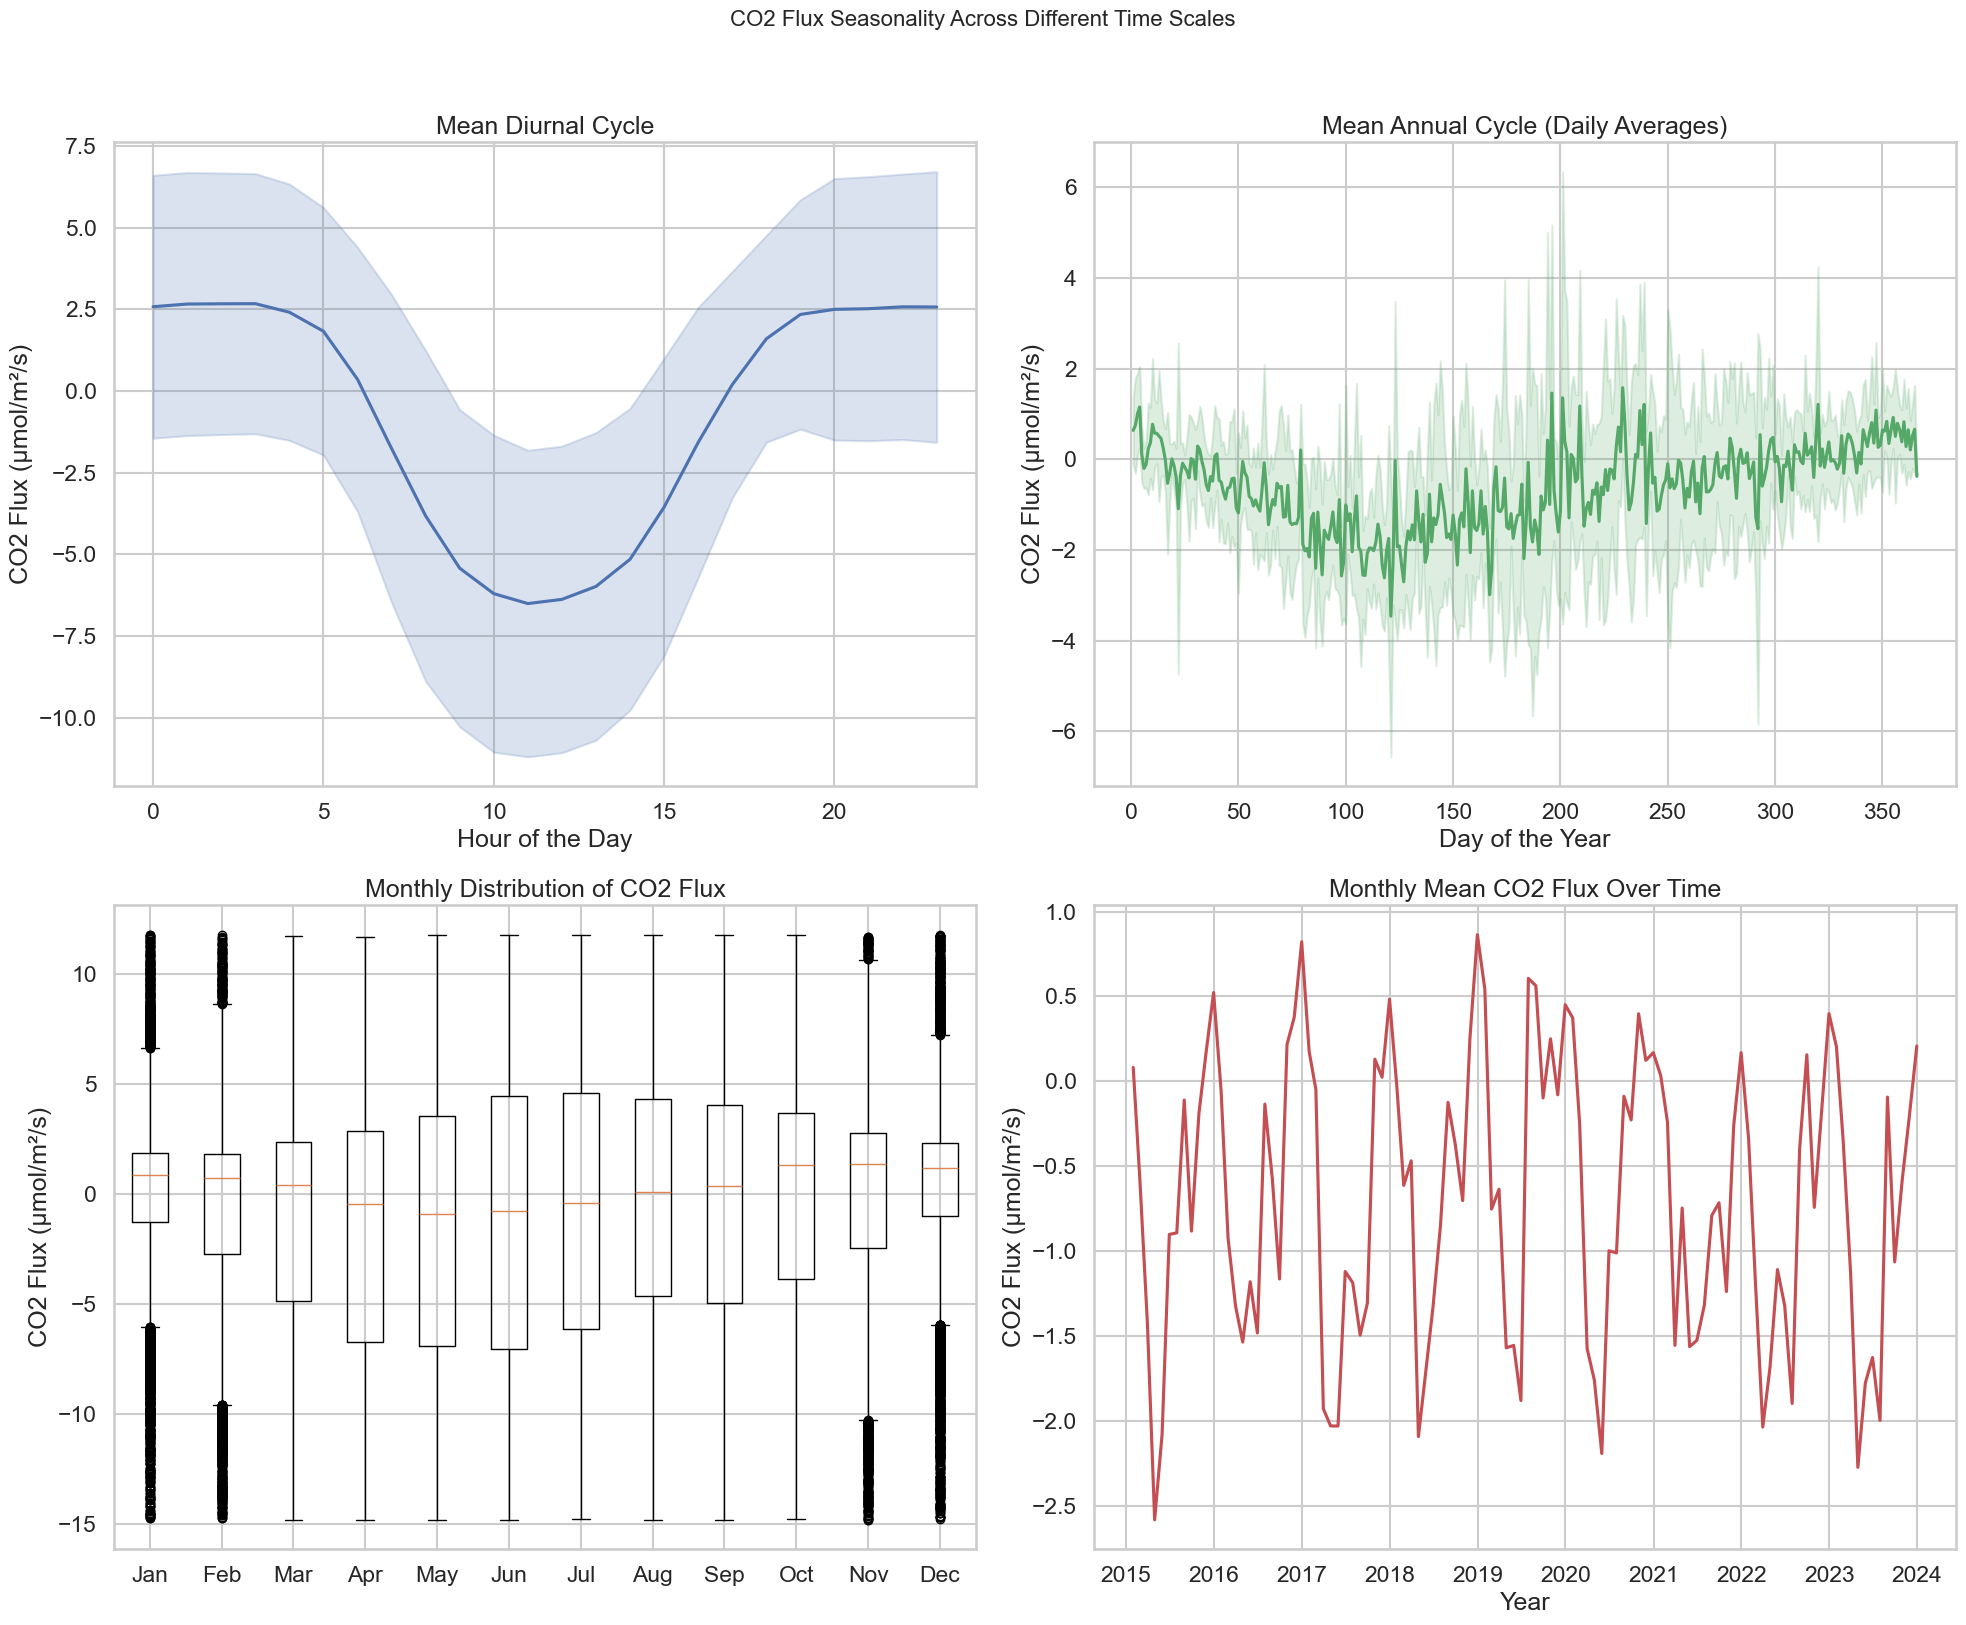

2025-02-19 16:38:15 DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x72020b850>



Statistical Summary of Seasonality:

1. Diurnal Cycle:
Maximum mean flux occurs at 3 hours: 2.67
Minimum mean flux occurs at 11 hours: -6.50

2. Annual Cycle:
Maximum annual mean flux on day 229: 1.58
Minimum annual mean flux on day 121: -3.46

3. Seasonal Amplitudes:
Diurnal Amplitude: 9.17
Annual Amplitude: 5.04


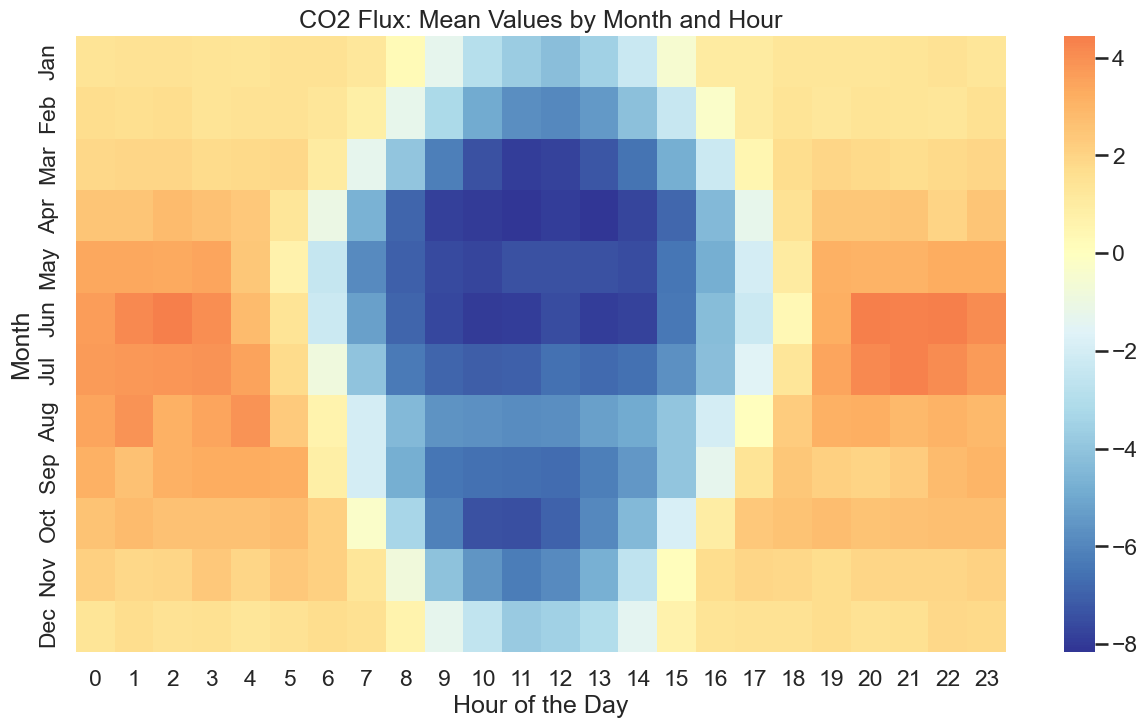

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_seasonality(data):
    """
    Analyzes and visualizes the seasonality of CO2 flux across different time scales.
    
    Args:
        data: Pandas Series with a DateTime index (e.g., flux_df['co2_flux_filled']).
    
    Returns:
        A tuple containing:
        - daily: DataFrame with mean and standard deviation of diurnal variations.
        - yearly_grouped: DataFrame with mean and standard deviation of annual variations.
        - monthly_means: DataFrame with mean CO2 flux for each month over multiple years.
    """
    
    # Convert input Series to a DataFrame for easier manipulation
    df = pd.DataFrame({'co2_flux': data})
    
    # Initialize figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('CO2 Flux Seasonality Across Different Time Scales', fontsize=16, y=1.02)
    
    # 1. Diurnal cycle analysis (mean and standard deviation)
    daily = df.groupby(df.index.hour)['co2_flux'].agg(['mean', 'std'])
    axes[0, 0].plot(daily.index, daily['mean'], 'b-', label='Mean')
    axes[0, 0].fill_between(daily.index, 
                            daily['mean'] - daily['std'],
                            daily['mean'] + daily['std'],
                            alpha=0.2, color='b')
    axes[0, 0].set_title('Mean Diurnal Cycle')
    axes[0, 0].set_xlabel('Hour of the Day')
    axes[0, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 0].grid(True)
    
    # 2. Annual cycle analysis (daily means)
    yearly = df.resample('D').mean()
    yearly_grouped = yearly.groupby(yearly.index.dayofyear)['co2_flux'].agg(['mean', 'std'])
    axes[0, 1].plot(yearly_grouped.index, yearly_grouped['mean'], 'g-', label='Mean')
    axes[0, 1].fill_between(yearly_grouped.index,
                            yearly_grouped['mean'] - yearly_grouped['std'],
                            yearly_grouped['mean'] + yearly_grouped['std'],
                            alpha=0.2, color='g')
    axes[0, 1].set_title('Mean Annual Cycle (Daily Averages)')
    axes[0, 1].set_xlabel('Day of the Year')
    axes[0, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 1].grid(True)
    
    # 3. Monthly boxplots for variability analysis
    monthly = df.groupby(df.index.month)['co2_flux']
    axes[1, 0].boxplot([monthly.get_group(i) for i in range(1, 13)],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[1, 0].set_title('Monthly Distribution of CO2 Flux')
    axes[1, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 0].grid(True)
    
    # 4. Long-term monthly mean trends
    monthly_means = df.resample('M').mean()
    axes[1, 1].plot(monthly_means.index, monthly_means['co2_flux'], 'r-')
    axes[1, 1].set_title('Monthly Mean CO2 Flux Over Time')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 1].grid(True)
    
    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()
    
    # Display statistical insights related to seasonality
    print("\nStatistical Summary of Seasonality:")
    
    print("\n1. Diurnal Cycle:")
    print(f"Maximum mean flux occurs at {daily['mean'].idxmax()} hours: {daily['mean'].max():.2f}")
    print(f"Minimum mean flux occurs at {daily['mean'].idxmin()} hours: {daily['mean'].min():.2f}")
    
    print("\n2. Annual Cycle:")
    print(f"Maximum annual mean flux on day {yearly_grouped['mean'].idxmax()}: {yearly_grouped['mean'].max():.2f}")
    print(f"Minimum annual mean flux on day {yearly_grouped['mean'].idxmin()}: {yearly_grouped['mean'].min():.2f}")
    
    # Compute seasonal amplitudes for daily and yearly cycles
    daily_range = daily['mean'].max() - daily['mean'].min()
    yearly_range = yearly_grouped['mean'].max() - yearly_grouped['mean'].min()
    
    print("\n3. Seasonal Amplitudes:")
    print(f"Diurnal Amplitude: {daily_range:.2f}")
    print(f"Annual Amplitude: {yearly_range:.2f}")
    
    # Generate heatmap of CO2 flux variations across months and hours
    pivot_data = df.pivot_table(
        values='co2_flux',
        index=df.index.month,
        columns=df.index.hour,
        aggfunc='mean'
    )
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=0,
                yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title('CO2 Flux: Mean Values by Month and Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Month')
    plt.show()
    
    return daily, yearly_grouped, monthly_means

# Execute the seasonality analysis
daily_patterns, yearly_patterns, monthly_trends = analyze_seasonality(flux_df['co2_flux_filled'])

# Optional: Save the results for further analysis
# daily_patterns.to_csv('daily_patterns.csv')
# yearly_patterns.to_csv('yearly_patterns.csv')
# monthly_trends.to_csv('monthly_trends.csv')

# Data Manipulation